# Diagnostic Maps of Network Input Data

In [1]:
require(data.table)
require(ggplot2)
require(maps)

Loading required package: data.table
Loading required package: ggplot2
Loading required package: maps


In [2]:
states <- map_data("state")

## Nodes & Links

In [3]:
nodes <- fread("nodes.tsv", stringsAsFactors=TRUE)
summary(nodes)

                                              Network ID        X          
 00199 | Aberdeen--Bel Air South--Bel Air North, MD:  1   Min.   :-124.17  
 00280 | Abilene, TX                               :  1   1st Qu.:-112.02  
 00766 | Akron, OH                                 :  1   Median : -92.89  
 00820 | Alamogordo, NM                            :  1   Mean   : -96.00  
 00955 | Albany, OR                                :  1   3rd Qu.: -81.65  
 00970 | Albany--Schenectady, NY                   :  1   Max.   : -68.75  
 (Other)                                           :556                    
       Y          Area [km^2]       Production?     Cost [$]  Cost [$/yr]
 Min.   :25.97   Min.   :   0.00   Central:562   Min.   :0   Min.   :0   
 1st Qu.:34.09   1st Qu.:   0.00                 1st Qu.:0   1st Qu.:0   
 Median :38.49   Median :  91.64                 Median :0   Median :0   
 Mean   :37.93   Mean   : 362.25                 Mean   :0   Mean   :0   
 3rd Qu.:41.63   3rd Q

In [4]:
links <- fread("links.tsv", stringsAsFactors=TRUE)
summary(links)

     Network ID                    From Node ID                    To Node ID  
 Link 1   :   1   24850 | Duluth, MN--WI :  13   24850 | Duluth, MN--WI :  13  
 Link 10  :   1   89245 | Twin Falls, ID :  12   89245 | Twin Falls, ID :  12  
 Link 100 :   1   14158 | Carson City, NV:  11   14158 | Carson City, NV:  11  
 Link 1000:   1   32491 | Galveston, TX  :  11   32491 | Galveston, TX  :  11  
 Link 1001:   1   88948 | Tulsa, OK      :  11   88948 | Tulsa, OK      :  11  
 Link 1002:   1   @ St. Marys, PA        :  11   @ St. Marys, PA        :  11  
 (Other)  :3330   (Other)                :3267   (Other)                :3267  
  Length [km]           Cost [$]  Cost [$/yr] Transmission?  Delivery?      
 Min.   :   0.9776   Min.   :0   Min.   :0    Mode:logical   Mode :logical  
 1st Qu.:  47.3074   1st Qu.:0   1st Qu.:0    TRUE:3336      FALSE:3336     
 Median :  95.1010   Median :0   Median :0    NA's:0         NA's :0        
 Mean   : 142.3850   Mean   :0   Mean   :0          

In [5]:
linkGeom <-rbind(
    links[nodes, on=c(`From Node ID`="Network ID")][, .(`Network ID`, `Order`=1, `X`, `Y`)],
    links[nodes, on=c(`To Node ID`="Network ID")][, .(`Network ID`, `Order`=2, `X`, `Y`)]
    )

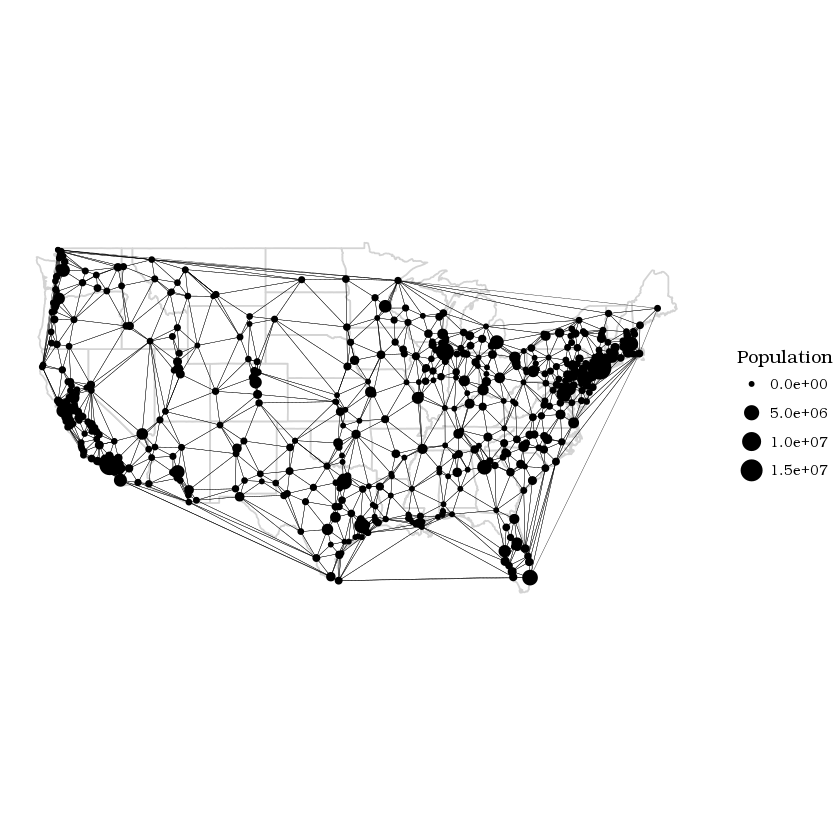

In [6]:
ggplot() + 
  geom_polygon(data=states, aes(x=long, y=lat, group=group), color="lightgray", fill="white") + 
  geom_line(data=linkGeom, aes(x=X, y=Y, group=`Network ID`), size=0.1) +
  geom_point(data=nodes, aes(x=X, y=Y, size=Population)) +
  coord_fixed(1.3) +
  guides(fill=FALSE) +
  theme_void()

## Existing Infrastructure

In [7]:
existings <- fread("existings.tsv", stringsAsFactors=TRUE)
summary(existings)

           Network ID       Year      Capacity [kg/yr]   Yield [upstream/kg]
 @ Anacortes, WA:  1   Min.   :2016   Min.   :    8474   Min.   :0          
 @ Anniston, AL :  1   1st Qu.:2016   1st Qu.:  337987   1st Qu.:0          
 @ Ardmore, OK  :  1   Median :2016   Median : 1540655   Median :0          
 @ Artesia, NM  :  1   Mean   :2016   Mean   : 9465766   Mean   :0          
 @ Ashtabula, OH:  1   3rd Qu.:2016   3rd Qu.: 9100870   3rd Qu.:0          
 @ Augusta, GA  :  1   Max.   :2016   Max.   :98753874   Max.   :0          
 (Other)        :161                                                        
  Cost [$/kg]
 Min.   :5   
 1st Qu.:5   
 Median :5   
 Mean   :5   
 3rd Qu.:5   
 Max.   :5   
             

In [8]:
existingsGeom <- existings[nodes, on="Network ID", nomatch=0][, .(`Network ID`, `Capacity [kg/yr]`, `X`, `Y`)]

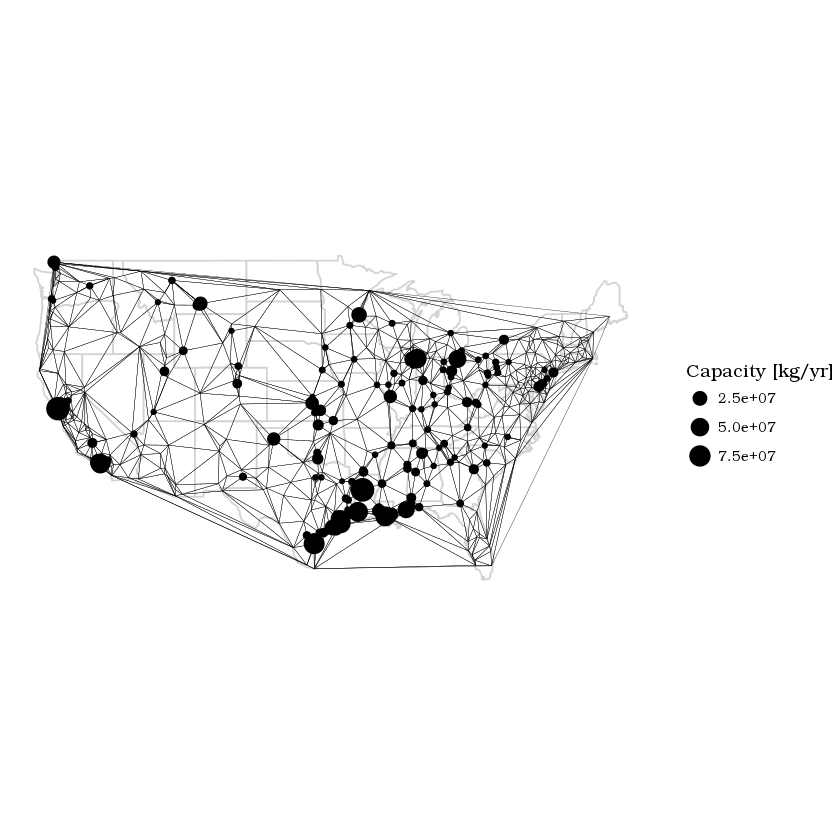

In [9]:
ggplot() + 
  geom_polygon(data=states, aes(x=long, y=lat, group=group), color="lightgray", fill="white") + 
  geom_line(data=linkGeom, aes(x=X, y=Y, group=`Network ID`), size=0.1) +
  geom_point(data=existingsGeom, aes(x=X, y=Y, size=`Capacity [kg/yr]`)) +
  coord_fixed(1.3) +
  guides(fill=FALSE) +
  theme_void()

## States

In [10]:
stateZones <- fread("states.tsv", stringsAsFactors=TRUE)[nodes, on="Network ID"][, .(`Network ID`, `Zone`, `Fraction`, `X`, `Y`)]

In [11]:
# Check for nodes that were not assigned a zone.
stateZones[is.na(Fraction), ]

Network ID,Zone,Fraction,X,Y


In [12]:
# Check for cases where the total fraction is not one.
stateZones[, .(Check=sum(`Fraction`)), by=`Network ID`][abs(Check - 1) > 1e-5, ]

Network ID,Check


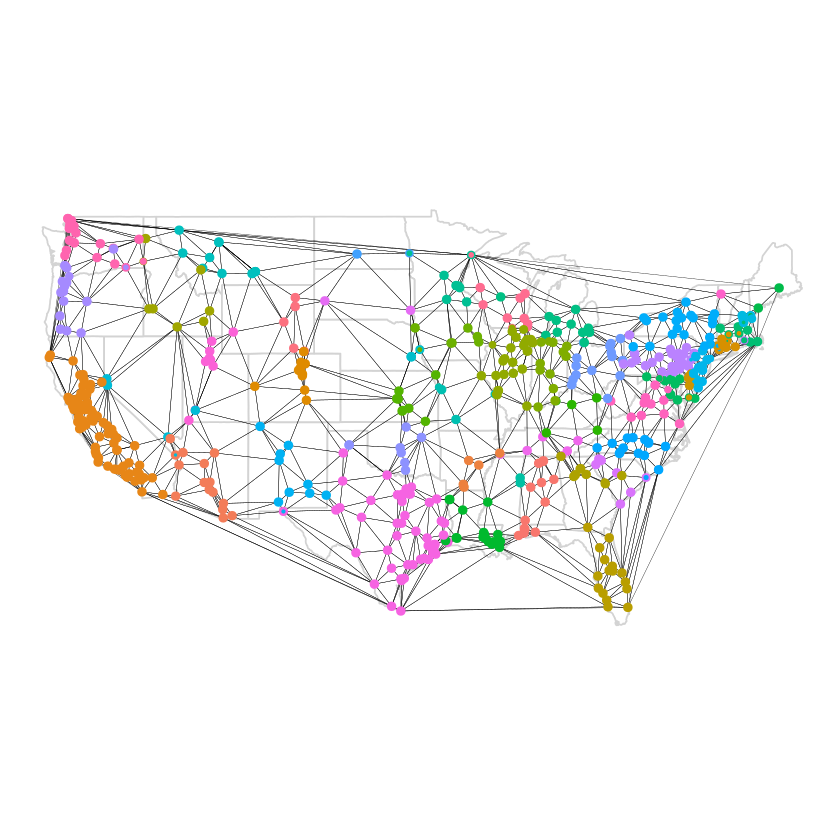

In [13]:
ggplot() + 
  geom_polygon(data=states, aes(x=long, y=lat, group=group), color="lightgray", fill="white") + 
  geom_line(data=linkGeom, aes(x=X, y=Y, group=`Network ID`), size=0.1) +
  geom_point(data=stateZones, aes(x=X, y=Y, size=Fraction, color=Zone)) +
  scale_size_continuous(range = c(0,2)) +
  coord_fixed(1.3) +
  guides(fill=FALSE, color=FALSE, size=FALSE) +
  theme_void()

## Census Divisions

In [14]:
censusZones <- fread("census-divisions.tsv", stringsAsFactors=TRUE)[nodes, on="Network ID"][, .(`Network ID`, `Zone`, `Fraction`, `X`, `Y`)]

In [15]:
# Check for nodes that were not assigned a zone.
censusZones[is.na(Fraction), ]

Network ID,Zone,Fraction,X,Y


In [16]:
# Check for cases where the total fraction is not one.
censusZones[, .(Check=sum(`Fraction`)), by=`Network ID`][abs(Check - 1) > 1e-5, ]

Network ID,Check


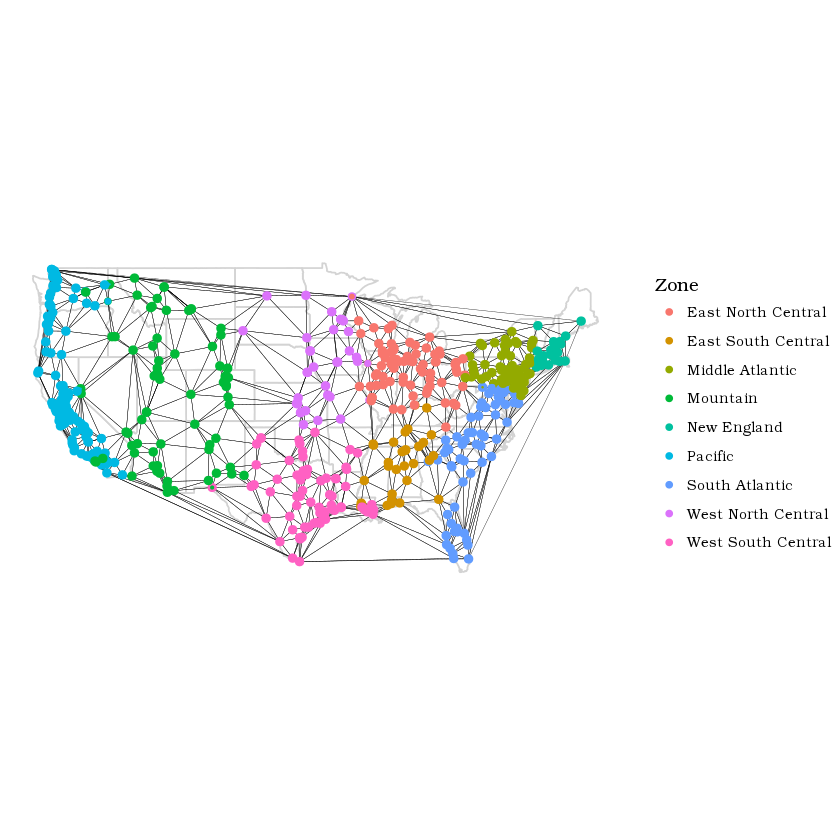

In [17]:
ggplot() + 
  geom_polygon(data=states, aes(x=long, y=lat, group=group), color="lightgray", fill="white") + 
  geom_line(data=linkGeom, aes(x=X, y=Y, group=`Network ID`), size=0.1) +
  geom_point(data=censusZones, aes(x=X, y=Y, size=Fraction, color=Zone)) +
    scale_size_continuous(range = c(0,2)) +
coord_fixed(1.3) +
  guides(fill=FALSE, size=FALSE) +
  theme_void()

## NERC Regions

In [18]:
nercZones <- fread("nerc-regions.tsv", stringsAsFactors=TRUE)[nodes, on="Network ID"][, .(`Network ID`, `Zone`, `Fraction`, `X`, `Y`)]

In [19]:
# Check for nodes that were not assigned a zone.
nercZones[is.na(Fraction), ]

Network ID,Zone,Fraction,X,Y


In [20]:
# Check for cases where the total fraction is not one.
nercZones[, .(Check=sum(`Fraction`)), by=`Network ID`][abs(Check - 1) > 1e-5, ]

Network ID,Check


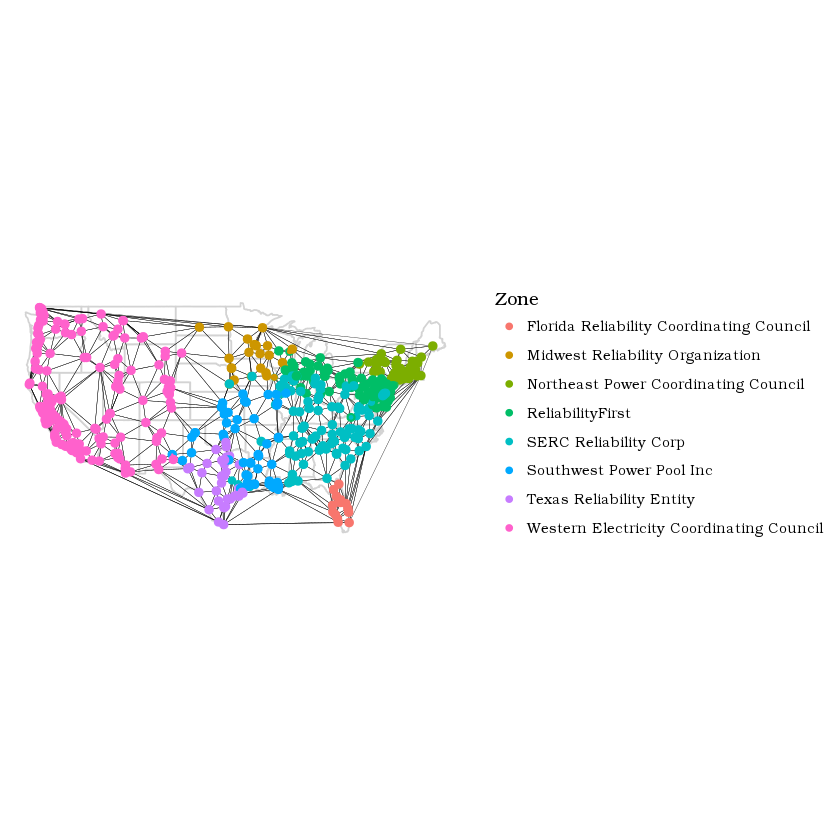

In [21]:
ggplot() + 
  geom_polygon(data=states, aes(x=long, y=lat, group=group), color="lightgray", fill="white") + 
  geom_line(data=linkGeom, aes(x=X, y=Y, group=`Network ID`), size=0.1) +
  geom_point(data=nercZones, aes(x=X, y=Y, size=Fraction, color=Zone)) +
  scale_size_continuous(range = c(0,2)) +
  coord_fixed(1.3) +
  guides(fill=FALSE, size=FALSE) +
  theme_void()

## Territories for Reporting Output

In [22]:
territories <- fread("territories.tsv", stringsAsFactors=TRUE)[nodes, on="Network ID"][, .(`Network ID`, `Territory`, `Fraction`, `X`, `Y`)]

In [23]:
# Check for nodes that were not assigned a territory.
territories[is.na(Fraction), ]

Network ID,Territory,Fraction,X,Y


In [24]:
# Check for cases where the total fraction is not one.
territories[, .(Check=sum(`Fraction`)), by=`Network ID`][abs(Check - 1) > 1e-5, ]

Network ID,Check


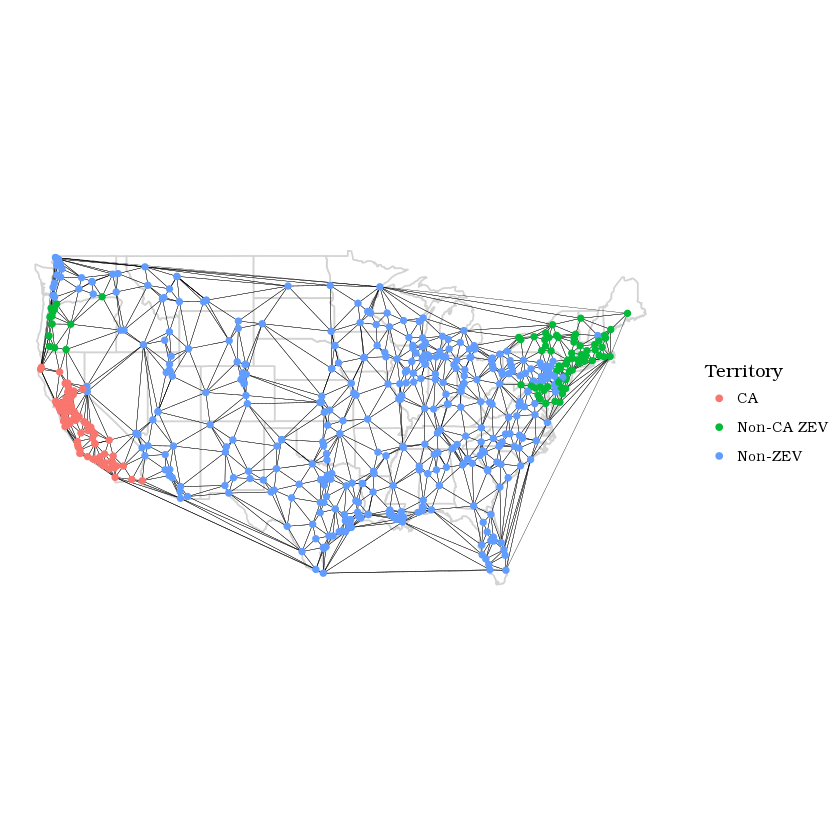

In [25]:
ggplot() + 
  geom_polygon(data=states, aes(x=long, y=lat, group=group), color="lightgray", fill="white") + 
  geom_line(data=linkGeom, aes(x=X, y=Y, group=`Network ID`), size=0.1) +
  geom_point(data=territories, aes(x=X, y=Y, size=Fraction, color=Territory)) +
  scale_size_continuous(range = c(0,2)) +
  coord_fixed(1.3) +
  guides(fill=FALSE, size=FALSE) +
  theme_void()